## Import all of used library

is needed to run all of the cells in this section

In [ ]:
# Import library that needed for colab
from google.colab import drive # colab only
from google.colab import files # colab only

# To remove all warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import zipfile
import pandas as pd
import requests
import random
import calendar
import time

from PIL import Image

from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive
from shutil import rmtree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from tensorflow import lite, cast, float32
from tensorflow import saved_model

from imblearn.over_sampling import RandomOverSampler 

In [ ]:
# To mounting Google Drive

def google_drive_mount(mounting=False):
  if mounting:
    drive.mount('/content/drive')

In [ ]:
# Download the file

def download_file(urls, unzip=True, remove_after_unzip=False, google_drive=False, filename='tmp', ext='zip'):

  url = urls
  CHUNK_SIZE = 32768
  file_tmp = f'{filename}.{ext}'

  # If Downloading from Google Drive
  if google_drive:

    # Get the token
    def get_confirm_token(response):
      
      for key, value in response.cookies.items():
        if key.startswith('download_warning'):
          return value
      return None
    
    url_raw = 'https://docs.google.com/uc?export=download'
    file_id = url.split('/')[-2] # Split the file id
    session = requests.Session() # Get session
    response = session.get(url_raw, params={'id': file_id}, stream=True) # Get the response
    token = get_confirm_token(response) # Get the token

    # If there is token
    if token:
      response = session.get(url_raw, params={'id': file_id, 'confirm': token}, stream=True) # Get the response
    
    # Save the response as zip file
    with open(file_tmp, 'wb') as f:
      for chunk in response.iter_content(CHUNK_SIZE):
        if chunk:
          f.write(chunk)
  
  # If not from Google Drive
  else:
    filedata = get_file(origin=url, fname=os.path.join(os.getcwd(), file_tmp)) # Get the response from URL

  # Extract the zip files
  if unzip:
    local_zip = file_tmp
    zip_ref = zipfile.ZipFile(local_zip, 'r') # Extract 
    zip_ref.extractall(f'{os.getcwd()}/') # Extract
    zip_ref.close()
    # Remove the zip file after unzip
    if remove_after_unzip:
      os.remove(file_tmp)  
  
  # If not a zip file
  else:
    return file_tmp

## Analysis and pre-processing the datasets
Analysis and pre-processing the new converted datasets from Google Drive: https://drive.google.com/file/d/1-dOK_6g-Bkf8_SKcZKUwiCIj8TSqC7O5/view?usp=sharing


Download the file

In [ ]:
download_file('https://drive.google.com/file/d/1-dOK_6g-Bkf8_SKcZKUwiCIj8TSqC7O5/view?usp=sharing', remove_after_unzip=True, google_drive=True)

# Checking the downloaded file
len(os.listdir('data'))

2370

Defining image and label from dataset

In [ ]:
def define_dataset(csv, unique=False, show_df = False):

  df = pd.read_csv(csv) # Reading the csv files from pandas
  img = df['image_id'] # Define the Feature 
  target = df['cell_type_idx'].values # Define the Labels
  df_unique = df['cell_type'].value_counts() # Amout of unique value

  if unique: # Counting unique values
    return img, target, df_unique
  
  if show_df:
    return img, target, df
  
  else:
    return img, target

In [ ]:
# Defining dataset into labels and features
img, target, df_unique = define_dataset('metadata.csv', unique=True)

In [ ]:
df_unique

Benign       1257
Malignant    1113
Name: cell_type, dtype: int64

Splitting the data into train, validation and test

In [ ]:
def split_data(x, y, test_size=0.2, validation_size=0.05, balancing=False):
  
  # Balancing the datasets, if the datasets not balanced so this function will balanced them
  def balancing_dataset(x_train, x_val, y_train, y_val):
    
    # Balancing with OverSampler method from Imbalanced Learn
    # Source: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
    oversample = RandomOverSampler()
    x_train, y_train  = oversample.fit_resample(x_train.values.reshape(-1,1),y_train)
    x_val, y_val  = oversample.fit_resample(x_val.values.reshape(-1,1),y_val)
    
    return x_train, x_val, y_train, y_val
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_size)

  # If balancing is True, so the datasets will be balancing
  if balancing:
    x_train, x_val, y_train, y_val = balancing_dataset(x_train, x_val, y_train, y_val)
  
  # Print the results of splitting
  print("Train: ", x_train.shape[0]), print("Val: ", x_val.shape[0]), print("Test: ", x_test.shape[0]), 
  
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
# Splitting into train, valid and test with balancing all of the data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(img, target, balancing=True, test_size=0.2, validation_size=0.05)

Train:  2390
Val:  124
Test:  474


Convert image to tensor

In [ ]:
def to_tensor(image_paths, oversample=True, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    if oversample: # If datasets is balanced
      img = load_img(f"data/{i[0]}.jpg", target_size=(size, size)) # Load the Image then resized them
    else:
      img = load_img(f"data/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs

In [ ]:
# We only balanced the Train and Validation data
# So, if we set oversample to True for x_test
# There will be errors
x_train = to_tensor(x_train, size=150) #size=299
x_val = to_tensor(x_val, size=150) #size=299
# x_test = to_tensor(x_test)

# Unbalanced datasets
#x_train = to_tensor(x_train, oversample=False)
#x_val = to_tensor(x_val, oversample=False)
x_test = to_tensor(x_test, oversample=False, size=150) # Since this is only the test dataset, no need to balanced this #size=299

100%|██████████| 474/474 [00:01<00:00, 364.89it/s]


Showing some picture from datasets

In [ ]:
class_names = ['Benign','Malignant']

def show_batch(x, y, figsize=12, subfigsize=5, n=25, no_axis=True):

  plt.figure(figsize=(figsize, figsize)) # Defining figure of the datasets
  
  for i in range(n): # Iterating through n datasets randomly
      ax = plt.subplot(subfigsize, subfigsize, i+1) # Defining frontend of figure
      plt.imshow(x[i]) # Showing the picture from datasets
      plt.title(class_names[y[i]]) # Showing class names
      
      # Remove axis from the figure
      if no_axis:
        plt.axis('off')

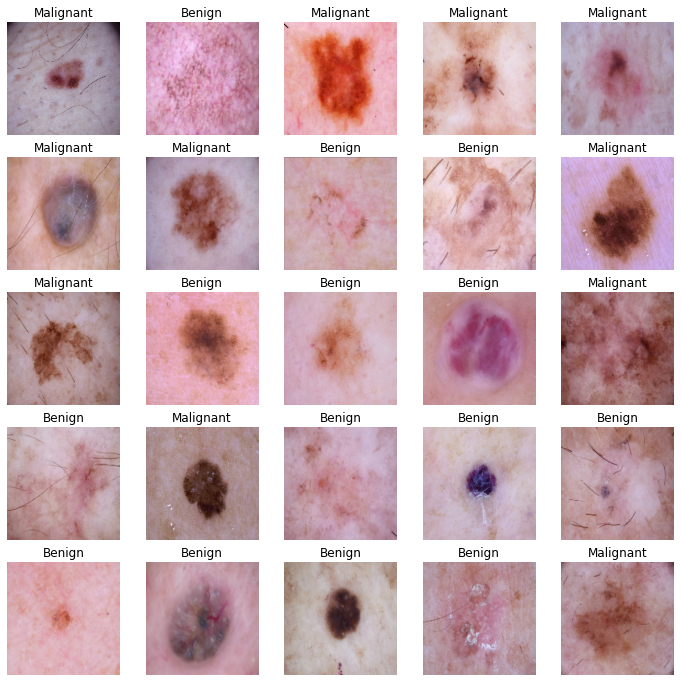

In [ ]:
# Showing images from the datasets
show_batch(x_test, y_test)

## Train
Defining the models and train the datasets based from the models that have been adjusted

Scoring the model 

In [ ]:
# Scoring saved models/checkpoint models

def scoring(model, x_test, y_test, class_names, verbose=0, 
            returning='confusion_matrix', show_predict=False, 
            show_confusion_matrix=False, show_score=False):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sn.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    score = model.evaluate(x_test, y_test, verbose=verbose)
    predicting = model.predict(x_test)
    pred = np.argmax(predicting, axis=1)
    conf = confusion_matrix(y_test, pred)  
  
    if returning in ['score', 'scoring']:
            if show_score:
                print("\n%s: %.2f%%\n" % (model.metrics_names[1], score[1]*100))
    
    if returning in ['predicting', 'pred', 'predict']:
            if show_predict:
                print("\nAccuracy: {0:.2f}%\n".format(accuracy_score(y_test, pred)*100))

    if returning in ['conf', 'confusion_matrix', 'confussion', 
                    'confusion', 'conf_mat', 'confusion_mat']:
            if show_confusion_matrix:
                plot_confusionmat(conf, class_names)    

Defining the models

In [ ]:
# Defining the models

def trainable_model(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, 
                    fine_tuning=False, dropout=0.25, base_model='MobileNet', 
                    regularizer=0.01, learning_rate=1e-4, epochs=15, verbose=1, 
                    metrics='accuracy', pool_size=2, rotation_range=30, 
                    zoom_range=0.15, width_shift_range=0.2, shear_range=0.15, 
                    horizontal_flip=True, fill_mode="nearest", height_shift_range=0.2,
                    weights="imagenet", include_top=False, summary=False, 
                    valid_generator=False, callbacks=None, generator=True,
                    checkpoint=None):
  
  dataset = (x_train, y_train, x_val, y_val)

  class_names = ['Benign', 'Malignant']

  BATCH_SIZE = batch_size
  INPUT_SHAPE = dataset[0][0].shape
  trainX = dataset[0]
  trainY = dataset[1]
  valX = dataset[2]
  valY = dataset[3]

  generators = ImageDataGenerator()
  train_dataset = generators.flow(trainX, trainY, batch_size=BATCH_SIZE)
  valid_dataset = generators.flow(valX, valY, batch_size=BATCH_SIZE)

  if generator:
    train_gen = ImageDataGenerator(rotation_range=rotation_range,
                                  zoom_range=zoom_range,
                                  width_shift_range=width_shift_range,
                                  height_shift_range=height_shift_range,
                                  shear_range=shear_range,
                                  horizontal_flip=horizontal_flip,
                                  fill_mode=fill_mode)

    train_dataset = train_gen.flow(trainX, trainY, batch_size=BATCH_SIZE)
    
    if valid_generator:
      valid_dataset = train_gen.flow(valX, valY, batch_size=BATCH_SIZE)
  
  if base_model in ['MobileNet','MobileNetV1']:
    base_model = MobileNet(weights=weights, 
                           include_top=include_top, 
                           input_tensor=Input(shape=INPUT_SHAPE)) # MobileNet: 83%, Epochs: 7

  elif base_model is 'MobileNetV2':
    base_model = MobileNetV2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # MobileNetV2: 75%, Epochs: 8

  elif base_model is 'VGG16':
    base_model = VGG16(weights=weights, 
                       include_top=include_top, 
                       input_tensor=Input(shape=INPUT_SHAPE)) # VGG16: 90%, Epochs: 7
  
  elif base_model in ['EfficientNetB0','EfficientNet']:
    base_model = EfficientNetB0(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # EfficientNetB0: 66%, Epochs: 6

  elif base_model is 'InceptionV3':
    base_model = InceptionV3(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Doesn't support by this dataset

  elif base_model is 'VGG19':
     base_model = VGG19(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # VGG19, 83%, Epochs: 10

  elif base_model is 'Xception':
    base_model = Xception(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Xception: 95%, Epochs: 9     

  elif base_model is 'DenseNet121':
    base_model = DenseNet121(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  elif base_model is 'DenseNet201':
    base_model = DenseNet201(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # DenseNet201: 82% Epochs: 6

  elif base_model is 'ResNet152V2':
    base_model = ResNet152V2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # ResNet152V2: 75%, Epochs: 6

  elif base_model is 'EfficientNetB5':
    base_model = EfficientNetB5(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this

  base_model.trainable=False

  if fine_tuning:
    base_model.trainable=True
    
  model = Sequential([base_model, 
                      AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                      Flatten(), 
                      Dense(64, activation='relu'),
                      Dropout(dropout), 
                      Dense(16, activation='relu'),
                      Dense(2, activation='sigmoid', kernel_regularizer=l2(regularizer)),
  ])

  model.compile(optimizer=Adam(lr=learning_rate), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=[metrics])

  if summary:
    model.summary()
  
  history = model.fit(train_dataset, 
                      epochs=epochs, 
                      validation_data=valid_dataset, 
                      verbose=verbose,
                      callbacks=[callbacks, checkpoint])
  
  scoring(model, x_test, y_test, class_names, returning='predict', show_predict=True)

  scoring(model, x_test, y_test, class_names, returning='conf', show_confusion_matrix=True)

  return history, model

Train the model

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

checkpoints = ModelCheckpoint('HAM10000_Xception_dropout0045_' + "{accuracy:.2f}acc.h5", verbose=1)

history, model = trainable_model(x_train, y_train, x_val, y_val, x_test, y_test,
                                 fine_tuning=True, epochs=20, base_model='Xception', 
                                 dropout=0.05, regularizer=0.1, batch_size=32,
                                 callbacks=callbacks, summary=True, checkpoint=checkpoints)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
average_pooling2d_6 (Average (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                524352    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                

Save the keras saved model to Google Drive, here is the link: https://drive.google.com/file/d/1-0ODyEWBJcERmvXXM5Ejk_VoxV7gI6SW/view?usp=sharing

In [ ]:
# Save the models to Google Drive

google_drive_mount(mounting=True)
copy("/content/HAM10000_Xception_dropout0045_0.96acc1.h5", "/content/drive/MyDrive/fix-datasets-new")

# Saved it to google drive: https://drive.google.com/file/d/1-0ODyEWBJcERmvXXM5Ejk_VoxV7gI6SW/view?usp=sharing

Mounted at /content/drive


'/content/drive/MyDrive/fix-datasets-new/HAM10000_Xception_dropout0045_0.97acc1.h5'

We succesfully created the model with 97% of accuracy